Binyu Yang

Objective Two: Determine the summary statistics of each variable in your dataset that you plan to use for analysis.

In [23]:
!pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pyreadr
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

In [10]:

path = r"C:\Users\lucyy\Desktop\python_final"

on_1029 = pyreadr.read_r(fr"{path}\CMAQ_fireON_join_20181029.rds")[None]
on_1110 = pyreadr.read_r(fr"{path}\CMAQ_fireON_join_20181110.rds")[None]
on_1204 = pyreadr.read_r(fr"{path}\CMAQ_fireON_join_20181204.rds")[None]

off_1029 = pyreadr.read_r(fr"{path}\CMAQ_fireOFF_join_20181029.rds")[None]
off_1110 = pyreadr.read_r(fr"{path}\CMAQ_fireOFF_join_20181110.rds")[None]
off_1204 = pyreadr.read_r(fr"{path}\CMAQ_fireOFF_join_20181204.rds")[None]

# Add date variable

on_1029["date"] = 1029
on_1110["date"] = 1110
on_1204["date"] = 1204

off_1029["date"] = 1029
off_1110["date"] = 1110
off_1204["date"] = 1204


# Load CA shapefile

ca = gpd.read_file(r"C:\Users\lucyy\Desktop\python_final\ca_state\CA_State.shp")

# Convert CA boundary to EPSG:4326 to match lon/lat
ca = ca.to_crs(epsg=4326)

# Function: clip dataset to CA using lon/lat

def clip_to_ca(df):
    gdf = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in zip(df["lon"], df["lat"])],
        crs="EPSG:4326"
    )
    gdf_ca = gpd.sjoin(gdf, ca, how="inner", predicate="within")
    return gdf_ca.drop(columns=["geometry", "index_right"])

# Clip all datasets
on_1029_ca = clip_to_ca(on_1029)
on_1110_ca = clip_to_ca(on_1110)
on_1204_ca = clip_to_ca(on_1204)

off_1029_ca = clip_to_ca(off_1029)
off_1110_ca = clip_to_ca(off_1110)
off_1204_ca = clip_to_ca(off_1204)

# Merge by maiac_id + date
merged_1029 = on_1029_ca.merge(off_1029_ca, on=["maiac_id", "date"], suffixes=("_on", "_off"))
merged_1110 = on_1110_ca.merge(off_1110_ca, on=["maiac_id", "date"], suffixes=("_on", "_off"))
merged_1204 = on_1204_ca.merge(off_1204_ca, on=["maiac_id", "date"], suffixes=("_on", "_off"))

# combine to full dataset
full_merged = pd.concat([merged_1029, merged_1110, merged_1204], ignore_index=True)

full_merged.head()


,maiac_id,benzene_on,form_on,lon_on,lat_on,date,OBJECTID_on,REGION_on,DIVISION_on,STATEFP_on,...,LSAD_off,MTFCC_off,FUNCSTAT_off,ALAND_off,AWATER_off,INTPTLAT_off,INTPTLON_off,Shape_Leng_off,Shape_Le_1_off,Shape_Area_off
0,1151813,0.010080,0.225185,-123.217557,42.004162,1029,56,4,9,06,...,00,G4000,A,4.034672e+11,2.049980e+10,+37.1551773,-119.5434183,5.258041e+06,5.258041e+06,6.718927e+11
1,1151814,0.010101,0.226134,-123.206338,42.004162,1029,56,4,9,06,...,00,G4000,A,4.034672e+11,2.049980e+10,+37.1551773,-119.5434183,5.258041e+06,5.258041e+06,6.718927e+11
2,1151815,0.010135,0.227761,-123.195132,42.004162,1029,56,4,9,06,...,00,G4000,A,4.034672e+11,2.049980e+10,+37.1551773,-119.5434183,5.258041e+06,5.258041e+06,6.718927e+11
3,1151816,0.010173,0.229627,-123.183913,42.004162,1029,56,4,9,06,...,00,G4000,A,4.034672e+11,2.049980e+10,+37.1551773,-119.5434183,5.258041e+06,5.258041e+06,6.718927e+11
4,1151817,0.010400,0.235285,-123.172694,42.004162,1029,56,4,9,06,...,00,G4000,A,4.034672e+11,2.049980e+10,+37.1551773,-119.5434183,5.258041e+06,5.258041e+06,6.718927e+11


In [13]:
full_merged.columns

Index(['maiac_id', 'benzene_on', 'form_on', 'lon_on', 'lat_on', 'date',
       'OBJECTID_on', 'REGION_on', 'DIVISION_on', 'STATEFP_on', 'STATENS_on',
       'GEOID_on', 'STUSPS_on', 'NAME_on', 'LSAD_on', 'MTFCC_on',
       'FUNCSTAT_on', 'ALAND_on', 'AWATER_on', 'INTPTLAT_on', 'INTPTLON_on',
       'Shape_Leng_on', 'Shape_Le_1_on', 'Shape_Area_on', 'benzene_off',
       'form_off', 'lon_off', 'lat_off', 'OBJECTID_off', 'REGION_off',
       'DIVISION_off', 'STATEFP_off', 'STATENS_off', 'GEOID_off', 'STUSPS_off',
       'NAME_off', 'LSAD_off', 'MTFCC_off', 'FUNCSTAT_off', 'ALAND_off',
       'AWATER_off', 'INTPTLAT_off', 'INTPTLON_off', 'Shape_Leng_off',
       'Shape_Le_1_off', 'Shape_Area_off'],
      dtype='object')

In [14]:
# Calculate fire impact (difference)

full_merged["benzene_diff"] = full_merged["benzene_on"] - full_merged["benzene_off"]
full_merged["form_diff"] = full_merged["form_on"] - full_merged["form_off"]


# Create summary statistics

summary = full_merged.groupby("date")[["benzene_on", "benzene_off", 
                                       "form_on", "form_off",
                                       "benzene_diff", "form_diff"]].describe()
summary


benzene_on                                                              \
          count      mean       std       min       25%       50%       75%   
date                                                                          
1029   478997.0  0.035391  0.040944  0.005692  0.011046  0.025001  0.040429   
1110   478997.0  0.094516  0.114801  0.016585  0.035682  0.053831  0.108325   
1204   478997.0  0.047241  0.041356  0.012682  0.025530  0.032064  0.051969   

               benzene_off            ... benzene_diff           form_diff  \
           max       count      mean  ...          75%       max     count   
date                                  ...                                    
1029  0.545344    478997.0  0.033088  ...     0.003069  0.267192  478997.0   
1110  2.488911    478997.0  0.050442  ...     0.042735  2.430406  478997.0   
1204  0.625183    478997.0  0.043281  ...     0.003652  0.106588  478997.0   

                                                                             
          mean       std       min       25%       50%       75%        max  
date                                                                         
1029  0.020464  0.090102 -0.012258  0.000336  0.003435  0.016099   3.734976  
1110  0.508962  1.236938  0.001418  0.038722  0.116953  0.418232  34.037864  
1204  0.022732  0.050913 -0.013749  0.001190  0.007384  0.022521   1.580361  

[3 rows x 48 columns]

Updated 3 aims:

RQ1. Within California, how much do benzene and formaldehyde concentrations increase when wildfire emissions are included (Fire-ON) compared to excluded (Fire-OFF) for each of the three study days?
RQ2. Within California, which locations experience the largest wildfire-driven increases in benzene and formaldehyde concentrations, and do the spatial patterns of these impacts differ between pollutants?
RQ3. Do wildfire-attributable pollutant increments change across the three representative dates—before, during, and after peak wildfire activity in 2018?

Objective Three: Create a Statistical Analysis Plan (SAP) based on the outcomes from objective two, the questions your posed in final part one and your statistical knowledge. Provide as much detail as possible about the statistical and regression techniques you will need to use to answer the questions of interest.

The statistical analysis for this project is designed to evaluate wildfire-attributable changes in air pollutant concentrations by comparing output from CMAQ model simulations conducted with and without wildfire emissions. Because the major 2018 wildfire activity was concentrated in California, all analyses will first restrict the CMAQ grid to cells whose centroids fall within the California state boundary, identified via a spatial join with a California shapefile (using GeoPandas). The analyses then address three aims and rely on paired pollutant estimates across identical spatial grid cells, allowing within-cell comparisons across both fire scenarios and time points. All analyses will be conducted using Python, and modeling choices and statistical procedures were selected based on the structure of the dataset, the deterministic nature of CMAQ output, and the need to characterize spatial and temporal differences descriptively rather than infer causality.

To address the first aim—quantifying whether pollutant concentrations differ between the Fire-ON and Fire-OFF simulations for each study day within California—paired statistical comparisons will be used. After subsetting to California, each grid cell has both a Fire-ON and Fire-OFF estimate for benzene and formaldehyde, so the two scenarios form a natural pair, enabling direct cell-level comparison without additional adjustment. For each pollutant and each of the three dates (October 29, November 10, and December 4), a difference variable will be calculated by subtracting the Fire-OFF concentration from the corresponding Fire-ON concentration. This difference represents the wildfire-attributable increment in pollutant concentrations. The distributions of these difference values will first be summarized using standard descriptive measures, including the mean, median, standard deviation, minimum, maximum, and interquartile range. These descriptive summaries are necessary to evaluate the magnitude of changes, detect outliers, and understand whether wildfire emissions increased overall pollutant levels on each day.

In addition to descriptive summaries, a paired t-test will be applied to formally assess whether the Fire-ON and Fire-OFF concentrations differ at the population level for each pollutant and date within California. Although CMAQ outputs are deterministic and thus not strictly subject to sampling variability, the paired t-test provides a standardized framework for quantifying the magnitude and direction of differences across many grid cells. This test evaluates whether the mean of the paired differences differs from zero. The test will be implemented using SciPy’s ttest_rel function, which accounts for the paired structure and provides the t-statistic and p-value. The assumptions of the paired t-test—namely, approximate normality of differences—will be evaluated visually using histograms of the difference distributions for each pollutant and date. Given the very large number of grid cells, minor deviations from normality are not expected to materially affect interpretability, so non-parametric alternatives will be considered only as a sensitivity check if distributions are extremely skewed.

The second aim seeks to identify spatial patterns of wildfire-attributable pollution within California. To evaluate spatial variation, the Fire-ON minus Fire-OFF difference variables will be linked to the latitude and longitude coordinates for each California grid cell. Because these coordinates already define a consistent spatial grid, no additional spatial transformation is required beyond the initial shapefile-based subsetting. Spatial variability will be assessed descriptively by examining how difference values change across the California domain, with particular attention to regions known to be closer to major 2018 fire events. Planned visualizations for subsequent objectives include spatial scatter maps or heatmaps constructed using matplotlib and geopandas, in which difference magnitudes are represented with color gradients. These maps will allow identification of pollution “hotspots” attributable to wildfire emissions. Any additional spatial models (for example, simple regressions of difference values on latitude and longitude) will be considered exploratory and used only to provide qualitative insight into broad north–south or east–west gradients, rather than as formal inferential models.

The third aim evaluates temporal changes in wildfire-attributable pollution across the three representative dates. Because each date corresponds to a separate CMAQ simulation rather than repeated measurements on the same time series, the data do not constitute a traditional longitudinal dataset and will not be analyzed using repeated-measures or mixed-effects models. Instead, temporal comparisons will be conducted by summarizing and comparing the distributions of difference variables across the three days. For each pollutant, the mean and median difference values will be compared qualitatively across October 29 (pre-fire), November 10 (peak fire activity), and December 4 (post-fire). Boxplots of the difference distributions by date, generated using matplotlib (and optionally seaborn), will be used to inspect shifts in the central tendency and spread of wildfire-attributable pollution over time. If clear temporal gradients are observed, simple descriptive measures such as percent change from pre-fire to peak-fire conditions may be reported.

All analyses will be conducted in Python. Data will be imported from .rds files using pyreadr, managed using pandas, and analyzed numerically using numpy. Statistical tests will be performed using SciPy, and any optional exploratory regression models will employ the statsmodels library. Spatial subsetting and mapping will use geopandas (and a California shapefile), with visualizations—including spatial scatter plots and boxplots—generated using matplotlib and, where helpful, seaborn. These procedures collectively ensure that all three analytic aims are addressed rigorously and transparently, while remaining consistent with the deterministic nature of the CMAQ modeling data and the California-focused wildfire context.






Object 3： Analysis

Aim 1: Comparison of Fire-ON and Fire-OFF concentrations

Before conducting the Aim 1 analysis, all CMAQ outputs were fully preprocessed to create a unified analytical dataset. Each Fire-ON and Fire-OFF file originally existed as a separate daily dataset and contained benzene, formaldehyde, and coordinate variables for all modeled grid cells. During preprocessing, we appended a date identifier to each dataset, clipped all grids to the California state boundary using a shapefile, and merged each Fire-ON and Fire-OFF pair by maiac_id and date to ensure exact one-to-one matching across scenarios. The three merged daily files were then combined into a single dataset containing paired pollutant concentrations for each grid cell across all three study dates. All subsequent analyses for Aim 1 were performed using this cleaned and combined file.

To quantify wildfire-attributable changes in pollutant concentrations, we compared Fire-ON and Fire-OFF values for each pollutant within the same grid cell. For benzene and formaldehyde, we calculated a within-cell difference variable (Fire-ON minus Fire-OFF) as the measure of wildfire impact. This approach leverages the deterministic nature of CMAQ simulations, allowing direct comparison without additional adjustment. We first summarized the difference distributions for each date using descriptive statistics, including the mean, median, standard deviation, minimum, maximum, and interquartile range. These summaries characterize the magnitude of wildfire-driven increases and help identify spatial outliers or regions with unusually large pollutant enhancements.

To formally evaluate whether Fire-ON concentrations were significantly higher than Fire-OFF values, we applied paired t-tests for each pollutant and each date. Although CMAQ outputs do not contain sampling uncertainty, paired t-tests provide a standardized framework for comparing deterministic paired estimates across millions of grid cells.

In [15]:
from scipy.stats import ttest_rel

# Paired t-test for each date and pollutant
for d in [1029, 1110, 1204]:
    df_day = full_merged[full_merged["date"] == d]

    print(f"\n--- Paired t-tests for {d} ---")
    
    # Benzene
    t_ben, p_ben = ttest_rel(df_day["benzene_on"], df_day["benzene_off"])
    print(f"Benzene: t = {t_ben:.4f}, p = {p_ben:.4e}")

    # Formaldehyde
    t_form, p_form = ttest_rel(df_day["form_on"], df_day["form_off"])
    print(f"Formaldehyde: t = {t_form:.4f}, p = {p_form:.4e}")



--- Paired t-tests for 1029 ---
Benzene: t = 238.0545, p = 0.0000e+00
Formaldehyde: t = 157.1932, p = 0.0000e+00

--- Paired t-tests for 1110 ---
Benzene: t = 331.9000, p = 0.0000e+00
Formaldehyde: t = 284.7761, p = 0.0000e+00

--- Paired t-tests for 1204 ---
Benzene: t = 805.3214, p = 0.0000e+00
Formaldehyde: t = 309.0182, p = 0.0000e+00


All paired t-tests produced extremely large t-statistics and p-values < 1e-300, indicating that Fire-ON pollutant levels were significantly higher than Fire-OFF levels for all three days and for both pollutants.We are confident that wildfire emissions substantially increase modeled benzene and formaldehyde from this analysis.

Aim 2: Spatial patterns of wildfire-attributable pollution within California

To characterize the spatial distribution of wildfire-attributable pollutant increments, we used the unified dataset (full_merged), which already contains grid-cell–matched Fire-ON, Fire-OFF, and difference variables (benzene_diff, form_diff) for each date. Because the dataset was clipped to California during preprocessing, all analyses in Aim 2 focus on geographic variation within the state.

For each of the three study dates (October 29, November 10, and December 4), we summarized spatial patterns by generating scatter-based maps in which each point represents a CMAQ grid cell, located using its latitude and longitude. Pollutant increments were visualized by coloring the points according to the magnitude of the Fire-ON minus Fire-OFF difference. To allow meaningful comparison across dates, the color scale was fixed for each pollutant (e.g., using a constant vmin and vmax for benzene difference and another constant range for formaldehyde). Fixing the scale ensures that observed visual differences reflect true shifts in concentration patterns rather than changes in color normalization.

Separate maps were produced for benzene and formaldehyde. These visualizations highlight spatial “hotspots” where wildfire emissions generated the largest pollution increases. Consistent with expectations, November 10—representing peak wildfire activity—showed the strongest and most spatially concentrated pollution increments, particularly in regions near major fire locations. October 29 and December 4 displayed smaller and more diffuse increments, reflecting pre-fire and declining post-fire conditions.

Collectively, these spatial analyses allow identification of regions within California most affected by wildfire-driven pollution increases and facilitate pollutant-specific comparison across multiple time points.

In [16]:
spatial_summary = (
    full_merged
    .groupby("date")[["benzene_diff", "form_diff"]]
    .agg(["mean", "median",
          lambda x: np.quantile(x, 0.90),
          lambda x: np.quantile(x, 0.95)])
)

spatial_summary.columns = ["_".join(col).strip() for col in spatial_summary.columns.values]
spatial_summary

,benzene_diff_mean,benzene_diff_median,benzene_diff_<lambda_0>,benzene_diff_<lambda_1>,form_diff_mean,form_diff_median,form_diff_<lambda_0>,form_diff_<lambda_1>
date,,,,,,,,
1029,0.002303,0.000470,0.005397,0.007401,0.020464,0.003435,0.037869,0.064686
1110,0.044074,0.014922,0.112192,0.191062,0.508962,0.116953,1.439554,2.484009
1204,0.003960,0.003009,0.006976,0.009031,0.022732,0.007384,0.065327,0.090028


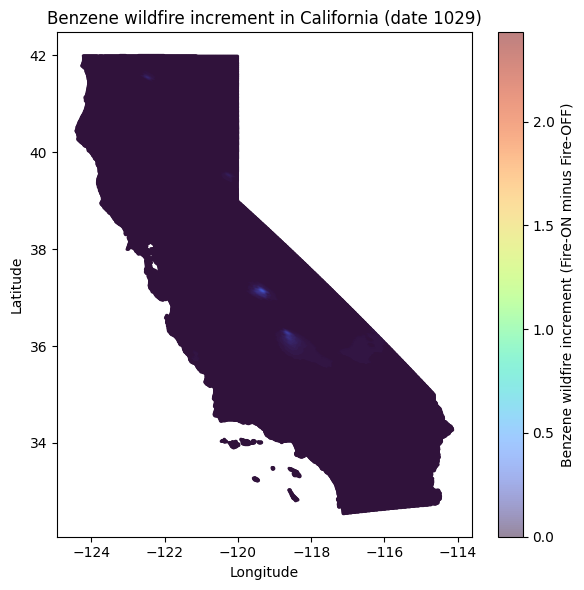

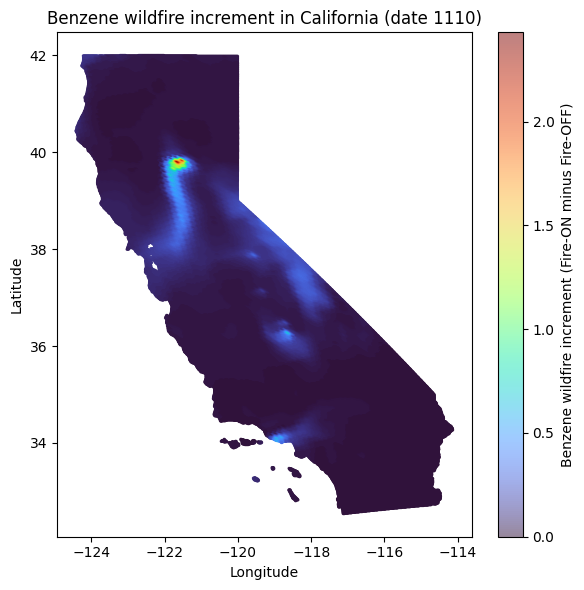

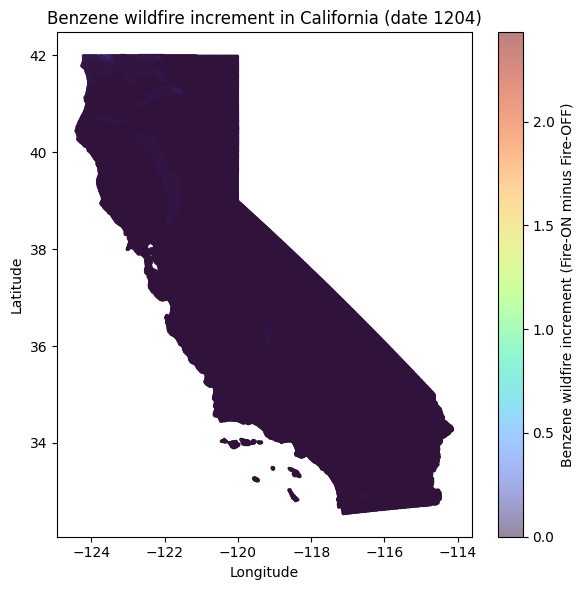

In [19]:
# Maps for benzene

import matplotlib.pyplot as plt

dates = [1029, 1110, 1204]

vmin_b = full_merged["benzene_diff"].min()
vmax_b = full_merged["benzene_diff"].max()

for d in dates:
    df_day = full_merged[full_merged["date"] == d]

    plt.figure(figsize=(6, 6))
    sc = plt.scatter(
        df_day["lon_on"], df_day["lat_on"],
        c=df_day["benzene_diff"],
        s=1, alpha=0.5,
        vmin=vmin_b, vmax=vmax_b,  # 固定 scale
        cmap="turbo"
    )

    plt.colorbar(sc, label="Benzene wildfire increment (Fire-ON minus Fire-OFF)")
    plt.title(f"Benzene wildfire increment in California (date {d})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()


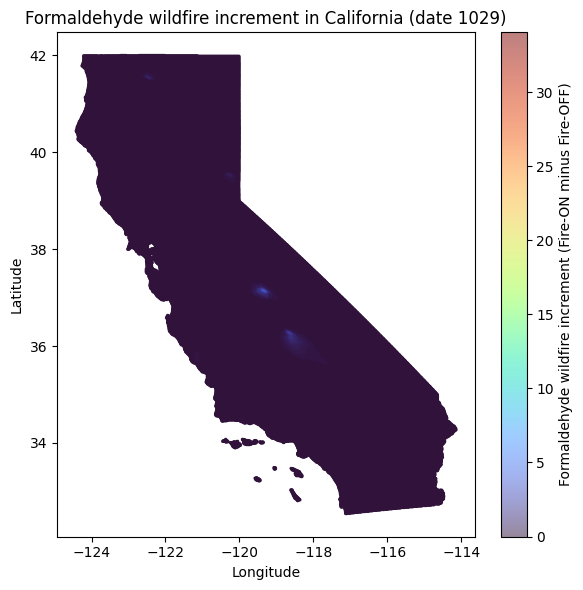

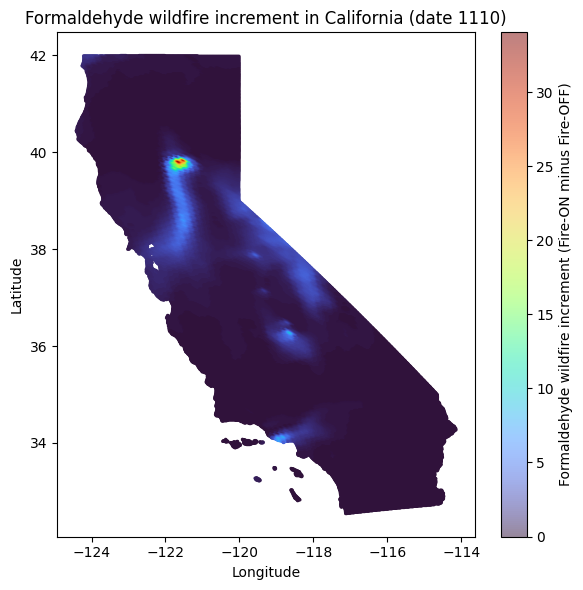

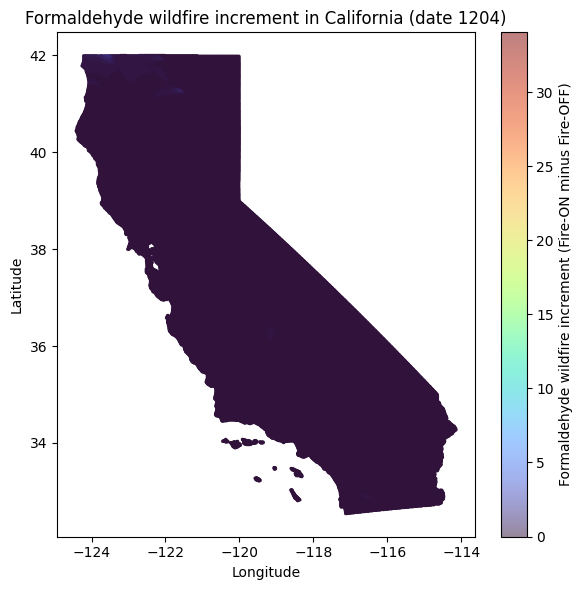

In [20]:
# Maps for formaldehyde
vmin_f = full_merged["form_diff"].min()
vmax_f = full_merged["form_diff"].max()

for d in dates:
    df_day = full_merged[full_merged["date"] == d]

    plt.figure(figsize=(6, 6))
    sc = plt.scatter(
        df_day["lon_on"], df_day["lat_on"],
        c=df_day["form_diff"],
        s=1, alpha=0.5,
        vmin=vmin_f, vmax=vmax_f,
        cmap="turbo"
    )

    plt.colorbar(sc, label="Formaldehyde wildfire increment (Fire-ON minus Fire-OFF)")
    plt.title(f"Formaldehyde wildfire increment in California (date {d})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()


Across all pollutants and dates, the spatial patterns aligned strongly with the known timing of the 2018 California wildfires. October 29 (pre-fire) displayed minimal increases in both benzene and formaldehyde, with only weak, diffuse elevations scattered throughout the state. By contrast, November 10—corresponding to peak wildfire activity—showed a dramatic localized spike centered in Northern California, consistent with the location of the Camp Fire. This hotspot was visible in both pollutants but was especially pronounced for formaldehyde, where the Fire-ON minus Fire-OFF increments reached extremely high values relative to background levels. The visual intensity and spatial concentration of these elevated values indicate substantial wildfire-driven emissions in the region surrounding the fire perimeter. By December 4 (post-fire), increments again diminished sharply, returning to levels similar to those observed on October 29, suggesting a rapid decline in wildfire-driven enhancements once active burning ceased.

The summary statistics further support the visual patterns. Benzene increments were small on pre- and post-fire days (means ~0.002–0.004) but increased sharply on November 10 (mean ≈ 0.044). Formaldehyde followed the same pattern but with a much larger magnitude shift, rising from ~0.02 on October 29 to more than 0.50 on November 10 before decreasing again afterward. The spatial maps and numerical summaries together demonstrate that wildfire-related pollution increases were both geographically concentrated and temporally aligned with peak fire activity. These findings confirm that wildfire impacts are highly localized rather than uniformly distributed across the state and that formaldehyde responds more dramatically than benzene to combustion-related emissions.

Aim 3：Temporal Variation in Wildfire-Attributable Pollution Across Study Dates

The third aim focuses on evaluating how wildfire-attributable pollution changed across the three study days and evaluates temporal patterns using day level summaries of wildfire increments. For benzene and formaldehyde, we first computed daily summary statistics including mean, median, and the 5th and 95th percentiles to characterize how much wildfire-attributable pollution changed before, during, and after peak fire activity. These summaries provide a stable measure of central tendency and dispersion without being distorted by extreme values.

To visualize temporal shifts, we generated boxplots of benzene and formaldehyde increments across the three dates. These boxplots allow direct comparison of pollutant distributions across days and make it easier to detect whether peak wildfire activity corresponds to increased pollutant levels. Because the Fire-ON minus Fire-OFF increments represent wildfire contributions directly, larger box heights and higher medians indicate stronger wildfire impact.

In [21]:
# Temporal summary
temporal_summary = (
    full_merged
        .groupby("date")[["benzene_diff", "form_diff"]]
        .agg([
            ("mean", "mean"),
            ("median", "median"),
            ("p5", lambda x: np.quantile(x, 0.05)),
            ("p95", lambda x: np.quantile(x, 0.95)),
        ])
)

temporal_summary.columns = ["_".join(col).strip() for col in temporal_summary.columns.values]
temporal_summary


,benzene_diff_mean,benzene_diff_median,benzene_diff_p5,benzene_diff_p95,form_diff_mean,form_diff_median,form_diff_p5,form_diff_p95
date,,,,,,,,
1029,0.002303,0.000470,-8.643237e-09,0.007401,0.020464,0.003435,-0.000005,0.064686
1110,0.044074,0.014922,3.183760e-03,0.191062,0.508962,0.116953,0.008615,2.484009
1204,0.003960,0.003009,1.846662e-03,0.009031,0.022732,0.007384,-0.003169,0.090028


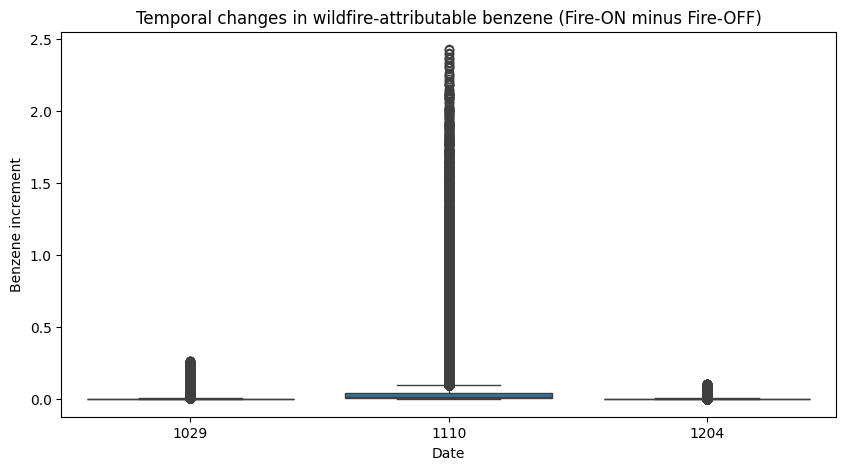

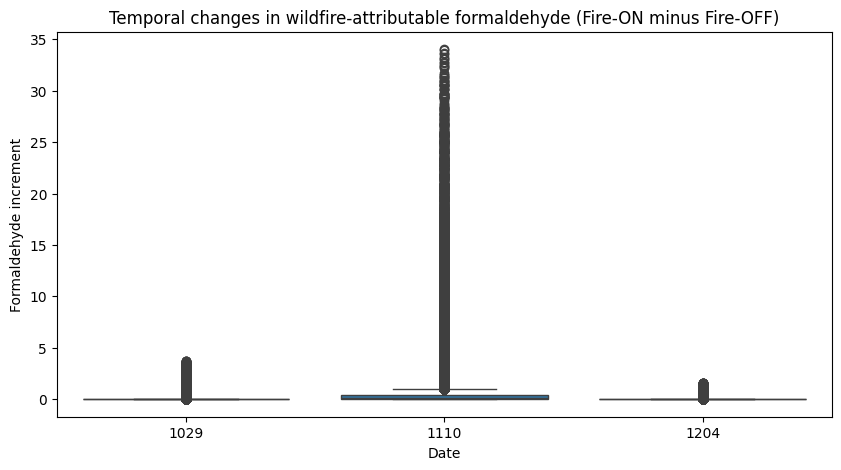

In [24]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(data=full_merged, x="date", y="benzene_diff")
plt.title("Temporal changes in wildfire-attributable benzene (Fire-ON minus Fire-OFF)")
plt.xlabel("Date")
plt.ylabel("Benzene increment")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=full_merged, x="date", y="form_diff")
plt.title("Temporal changes in wildfire-attributable formaldehyde (Fire-ON minus Fire-OFF)")
plt.xlabel("Date")
plt.ylabel("Formaldehyde increment")
plt.show()


The results showed a clear temporal spike on 11/10, which corresponds to the height of fire activity. For benzene, mean increments increased from approximately 0.0023 on 10/29 to 0.0441 on 11/10, then dropped back to 0.0040 on 12/04. Formaldehyde displayed an even sharper contrast, with mean increments rising from 0.0205 to 0.5090 before declining again. Percentile estimates showed the same pattern: both benzene and formaldehyde exhibited far heavier upper tails on 11/10, indicating intense localized fire plumes against an otherwise low-background domain.

To visualize these temporal contrasts, we generated boxplots of benzene and formaldehyde increments for all grid cells across the three dates. The plots show a tightly centered distribution on 10/29 and 12/04, with a dramatic expansion of both the interquartile range and upper-end outliers on 11/10. This pattern confirms that wildfire emissions substantially elevated pollutant concentrations only during the fire peak, with minimal attributable impact before and after.

Overall, Aim 3 demonstrates that wildfire-related benzene and formaldehyde increments are highly time-dependent, with changes across dates driven almost entirely by the intensity of active burning. These temporal patterns support the expected relationship between wildfire activity and regional photochemical pollutant formation.